# 소프트맥스 회귀

## 다항분류(다중 클래스 분류)의 이해

### 1) 다항 분류

- 이진 분류: 두 개의 선택지 중 하나를 고르는 문제 -> 마지막 층의 노드가 1개
- 다항 분류: 세 개 이상의 선택지 중 하나를 고르는 문제 -> 마지막 층의 노드가 여러개 

### 2) 소프트맥스 함수

- 신경망에서 마지막 층에 출력되는 값은 '입력에 대한 예측값'
- 예측값 [0.2,0.3,0.4] 을 가지고 정답과의 거리를 구한다고 생각할 때, 해당 클래스의 확률값으로 바꿔주는 함수를 소프트 맥스라고 한다.
- 확률값으로 바꿔준다는 것 : 두 예측값이 전체 예측에서 각각 차지하는 비율 
- 예측값이 음수로 나오거나 0으로 나올 수 있다. 이걸 해결하기 위해 음수가 들어오더라도 양수로 바꿔주는 함수를 찾아서 모든 예측값에 적용한다. 예측값을 자연상수 e를 밑으로 갖는 지수 함수를 사용한다.

- 다항 분류 활성화 함수
- 뉴런의 출력값에 대하여 class 분류를 위하여 마지막 단계에서 출력값에 대한 정규화를 해주는 함수.
- 결과물의 수치의 합은 언제나 1.0이다.
- 소프트맥스 함수의 출력값은 확률로 해석할 수 있다.

> 사진속 인물이 지금 슬픈 표정인지, 웃는 표정인지, 화난 표정인지 확률적으로 수치화한다고 했을때, 슬픔 (11%), 웃음 (29%), 화남(60%) 과같이 확률적 분류를 할 때 용이

![softmax](res/softmax.png)

- exp(x)는 지수함수(Exponential Function)이다(e는 자연상수).
- n은 출력층의 뉴런 수, yk는 그 중 k번째 출력을 뜻한다.

## #01 패키지 준비하기

In [59]:
# .cat rename같아서 라벨링 처리를 할 때 사용한다.
# np.where과 같다. 종속변수는 반드시 0 ~ 로 하는 숫자로 라벨링해줘야 한다. 
# 

# 첫번째 파라미터를 제거하면 get_dummmies를 쓰고, 아니면 to_categarycial?을 써라. 뭐?

#  산점도 행렬을 보는 이유는 왜봐? 상관관계를 보는게 아니다. hue에 걸린 데이터를 기준으로 군집을 묶는데, 뚜렷하게 그룹별로 나뉘는 특징이 있는지 확인 

# 종속변수는 1개 

# 왜 danse를 32개 주냐고 
# 마지막 Dense는 종속변수의 values_count만큼 줘야 한다. 

In [60]:
import sys
sys.path.append('../../')
import helper

import numpy as np
from pandas import read_excel, DataFrame, pivot_table
from matplotlib import pyplot as plt
import seaborn as sb

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

## #02. 데이터셋 준비하기

- 아이리스(붓꽃)의 꽃잎에 대한 각 부분의 너비와 길이등을 측정한 데이터이며 150개의 레코드로 구성.
- 꽃받침의 길이, 너비, 꽃잎의 길이, 너비등을 토대로 3가지로 나뉘는 붗꽃의 종류를 분류하는 학습 모델을 구성할 수 있다

In [61]:
origin = read_excel("https://data.hossam.kr/F03/iris.xlsx")
origin.head()

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


## #03. 데이터 전처리

### 결측치 확인

In [62]:
origin.isna().sum()

Sepal.Length    0
Sepal.Width     0
Petal.Length    0
Petal.Width     0
Species         0
dtype: int64

### 종속변수 라벨링을 위해 값의 종류 확인

In [63]:
uni = origin['Species'].unique()
print(uni)

['setosa' 'versicolor' 'virginica']


### 종속변수 라벨링

In [64]:
origin['Species'] = origin['Species'].astype('category').cat.rename_categories({'setosa': 0, 'virginica': 1, 'versicolor': 2})
origin['Species'].value_counts()

Species
0    50
2    50
1    50
Name: count, dtype: int64

## #04. 탐색적 데이터 분석

### 기본통계 확인

In [65]:
origin.describe()

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


### 산점도 행렬 확인

> 종속변수로 `hue`를 적용했을 때 뚜렷한 군집을 나타내는지 확인하기 위함

c:\Users\MegaIT302-02\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


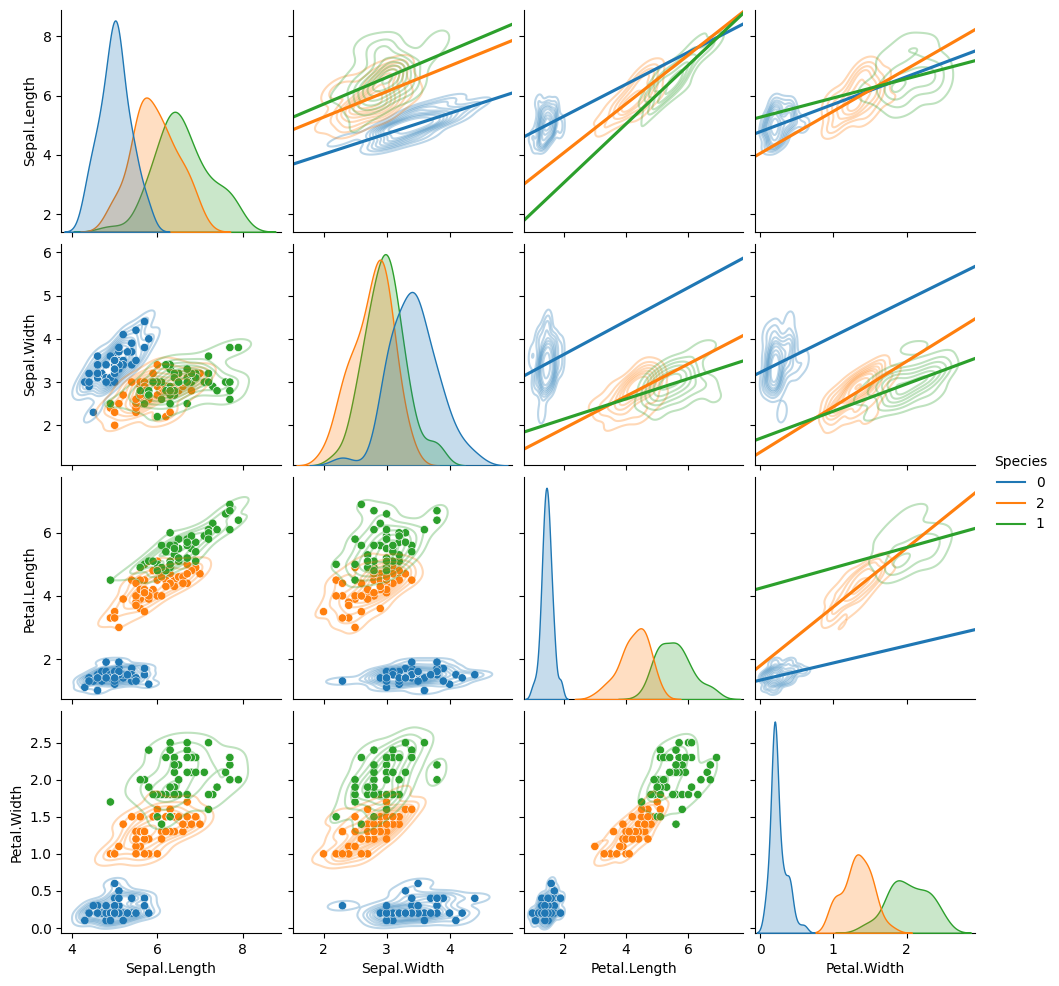

In [66]:
ax = sb.pairplot(origin, hue="Species", kind="kde", plot_kws={"alpha":0.3})
ax.map_lower(sb.scatterplot)
ax.map_upper(sb.regplot, scatter=False, truncate=False, ci=False)
plt.show()
plt.close()

## #05. 데이터셋 분할하기

### 랜덤시드 고정

In [67]:
np.random.seed(777)

### 훈련 데이터(독립변수)와 레이블(종속변수) 구분하기

In [68]:
x = origin.drop(['Species'], axis=1)
y = origin['Species']
x.shape, y.shape

((150, 4), (150,))

### 종속변수에 대한 one-hot-encoding

통상적인 더미변수 처리.

단 계산(회귀식)을 위한 처리가 아닌 분류를 위한 처리이므로 1번째 항목을 제외해서는 안된다.

In [69]:
y

0      0
1      0
2      0
3      0
4      0
      ..
145    1
146    1
147    1
148    1
149    1
Name: Species, Length: 150, dtype: category
Categories (3, int64): [0, 2, 1]

In [70]:
y_cate = to_categorical(y)
y_cate

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0

### 훈련 데이터와 검증 데이터로 분할

In [71]:
x_test.shape

(45, 4)

In [72]:
x_train, x_test, y_train, y_test = train_test_split(x, y_cate, test_size=0.3, random_state=777)
print("훈련용 데이터셋 크기: %s, 훈련용 레이블셋 크기: %s" % (x_train.shape, y_train.shape))
print("검증용 데이터셋 크기: %s, 검증용 레이블셋 크기: %s" % (x_test.shape, y_test.shape))

훈련용 데이터셋 크기: (105, 4), 훈련용 레이블셋 크기: (105, 3)
검증용 데이터셋 크기: (45, 4), 검증용 레이블셋 크기: (45, 3)


## #06. 모델 개발

### 모델 정의

In [82]:
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(4, )))
model.add(Dropout(0.3))
model.add(Dense(3, activation='softmax'))
model.add(Dropout(0.3))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 64)                320       
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 


 dense_12 (Dense)            (None, 3)                 195       
                                                                 
 dropout_5 (Dropout)         (None, 3)                 0         
                                                                 
Total params: 515 (2.01 KB)
Trainable params: 515 (2.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 학습하기

In [83]:
result = model.fit(x_train, y_train, epochs=500, validation_data=(x_test, y_test), callbacks = [
    EarlyStopping(monitor = 'val_loss', patience=5, verbose = 1),
    ReduceLROnPlateau(monitor= "val_loss", patience=3, factor = 0.5, min_lr=0.0001, verbose=1)
])

Epoch 1/500
4/4 [==============================] - 1s 43ms/step - loss: nan - acc: 0.2952 - val_loss: 1.2133 - val_acc: 0.3778 - lr: 0.0010
Epoch 2/500
4/4 [==============================] - 0s 10ms/step - loss: nan - acc: 0.3238 - val_loss: 1.1566 - val_acc: 0.3778 - lr: 0.0010
Epoch 3/500
4/4 [==============================] - 0s 13ms/step - loss: nan - acc: 0.3810 - val_loss: 1.1143 - val_acc: 0.3778 - lr: 0.0010
Epoch 4/500
4/4 [==============================] - 0s 12ms/step - loss: nan - acc: 0.3429 - val_loss: 1.0832 - val_acc: 0.3778 - lr: 0.0010
Epoch 5/500
4/4 [==============================] - 0s 11ms/step - loss: nan - acc: 0.3333 - val_loss: 1.0593 - val_acc: 0.3778 - lr: 0.0010
Epoch 6/500
4/4 [==============================] - 0s 9ms/step - loss: nan - acc: 0.4190 - val_loss: 1.0490 - val_acc: 0.4222 - lr: 0.0010
Epoch 7/500
4/4 [==============================] - 0s 11ms/step - loss: nan - acc: 0.3905 - val_loss: 1.0304 - val_acc: 0.3333 - lr: 0.0010
Epoch 8/500
4/4 [====

## #07. 학습 결과 평가

### 기본적인 머신러닝 학습결과 평가

In [84]:
# helper.tf_result_plot(result)

evaluate1 = model.evaluate(x_train, y_train)
print("최종 훈련 손실률: %f, 최종 훈련 정확도: %f" % (evaluate1[0], evaluate1[1]))

evaluate2 = model.evaluate(x_test, y_test)
print("최종 검증 손실률: %f, 최종 검증 정확도: %f" % (evaluate2[0], evaluate2[1]))

4/4 [==============================] - 0s 1ms/step - loss: 0.4393 - acc: 0.9714
최종 훈련 손실률: 0.439280, 최종 훈련 정확도: 0.971429
2/2 [==============================] - 0s 2ms/step - loss: 0.4060 - acc: 0.9556
최종 검증 손실률: 0.406009, 최종 검증 정확도: 0.955556


## #08. 학습 결과 적용

### 테스트 데이터에 대한 예측 결과 산정

In [76]:
results = model.predict(x_test)
data_count, case_count = results.shape
print("%d개의 검증 데이터가 각각 %d개의 경우의 수를 갖는다." % (data_count, case_count))

print(results)

2/2 [==============================] - 0s 3ms/step
45개의 검증 데이터가 각각 3개의 경우의 수를 갖는다.
[[0.0025102  0.5272918  0.470198  ]
 [0.90639454 0.02049455 0.07311091]
 [0.00337404 0.5973879  0.399238  ]
 [0.00557021 0.6220821  0.37234768]
 [0.0221579  0.40406796 0.57377416]
 [0.9468127  0.01011345 0.04307385]
 [0.00247848 0.6412803  0.3562413 ]
 [0.00351864 0.6208645  0.37561682]
 [0.9381134  0.0118064  0.05008023]
 [0.93118966 0.01387987 0.05493049]
 [0.00242068 0.56923056 0.42834884]
 [0.02362859 0.37705734 0.5993141 ]
 [0.03748114 0.40899444 0.5535244 ]
 [0.00707728 0.5556982  0.43722454]
 [0.00653087 0.56076026 0.43270886]
 [0.00502321 0.50437504 0.4906018 ]
 [0.8923703  0.02349971 0.08412998]
 [0.00899857 0.5805982  0.41040325]
 [0.8727716  0.02878417 0.09844421]
 [0.03472987 0.38929737 0.5759728 ]
 [0.04823445 0.31953487 0.6322307 ]
 [0.02270095 0.39452803 0.582771  ]
 [0.00115982 0.6416996  0.35714057]
 [0.90149677 0.02232364 0.07617958]
 [0.00836567 0.543912   0.4477224 ]
 [0.888399   0.02

### 가장 큰 확률 값의 인덱스들만 별도의 리스트로 생성

In [77]:
arg_results = np.argmax(results, axis=-1)
arg_results

array([1, 0, 1, 1, 2, 0, 1, 1, 0, 0, 1, 2, 2, 1, 1, 1, 0, 1, 0, 2, 2, 2,
       1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 2, 0, 0, 0, 2, 0, 0, 1, 2, 2,
       0], dtype=int64)

### 결과 데이터 셋 구성

In [78]:
result_df = DataFrame({
    '실제값': np.argmax(y_test, axis = -1),
    '분류결과': arg_results
})

result_df

,실제값,분류결과
0,1,1
1,0,0
2,1,1
3,1,1
4,2,2
5,0,0
6,1,1
7,1,1
8,0,0
9,0,0


### 컬럼에 따른 값의 종류 형태로 데이터 재배치

In [79]:
mdf = result_df.melt()
mdf.reset_index(inplace=True)
mdf

,index,variable,value
0,0,실제값,1
1,1,실제값,0
2,2,실제값,1
3,3,실제값,1
4,4,실제값,2
...,...,...,...
85,85,분류결과,0
86,86,분류결과,1
87,87,분류결과,2
88,88,분류결과,2


In [80]:
df = pivot_table(mdf, index='value', columns='variable', values='index', aggfunc='count')
df

variable,분류결과,실제값
value,,
0,17,17
1,18,17
2,10,11


In [81]:
cm = confusion_matrix(result_df['실제값'], result_df['분류결과'])
cmdf1 = DataFrame(cm, index=[['실제값', '실제값', '실제값'], [0,1,2]], 
                  columns=[['분류결과', '분류결과', '분류결과'], [0,1,2]])
cmdf1

분류결과        
         0   1   2
실제값 0   17   0   0
    1    0  17   0
    2    0   1  10